#### 세팅

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

### 나이브 베이즈
- 조건부확률 : 어떤 사건이 주어졌을 때, 해당 사건을 관찰할 확률
- 사후확률 :예측정보를 통합한 후 결과의 확률(이와 달리, 사전확률에서는 예측변수에 대한 정보를 고려하지 않는다.)
- 베이즈 분류기는 예측변수들이 범주형인 경우에 적합하다.
- 수치형 변수에 나이브 베이즈 방법을 적용하기 위해서는, 수치형 예측변수를 binning(비닝)하여 범주형으로 변환한 뒤, 알고리즘을 적용하거나, 조건부확률 P를 추정하기 위해 정규분포 같은 확률모형을 사용한다.
- 나이브 베이즈는 예측변수와 결과변수 모두 범주형(요인)이어야 한다.
- '각 출력 카테고리 안에서 어떤 예측변수의 카테고리가 가장 가능성이 높은가?'가 답하고자 하는 질문이다.
- 그리고 이 정보는 주어진 예측변수 값에 대해, 결과 카테고리의 확률을 추정하는 것으로 바꾼다.

In [9]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


### 판변분석
- 공분산 : 하나의 변수가 다른 변수와 함꼐 변화하는 정도(유사한 크기와 방향)를 측정하는 지표
- 판별함수 : 예측변수에 적용했을 때, 클래스 구분을 최대화하는 함수
- 판별 가중치 : 판별함수를 적용하여 얻은 점수를 말하며, 어떤 클래스에 속할 확률을 추정하는데 사용된다.
- 선형판별 분석(LDA)은 '내부'제곱합SS(그룹 안의 변동을 측정)에 대한 '사이' 제곱합SS(두 그룹 사이의 편차를 측정)의 비율을 최대화하는 것을 목표로 한다.
- 판별분석은 예측병수나 결과변수가 범주형이든 연속형이든 상관없이 잘 동작한다.
- 공분산행렬을 사용하여 한 클래스와 다른 클래스에 속한 데이터들을 구분하는 선형판별함수를 계산할 수 있다.
- 이 함수를 통해 각 레코드가 어떤 클래스에 속할 가중치 혹은 점수(각 클래스당 점수)를 구한다.

In [4]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [5]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


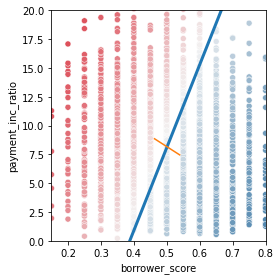

In [6]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

### 로지스틱 회귀
- 로짓(logit) : (0~1이 아니라) +-무한대의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수
- 오즈(odds) : '실패'(0)에 대한 '성공'(1)의 비율
- 로그 오즈(log odds) : 변환 모델(선형)의 응답변수. 이값을 통해 확률을 구한다.
- 로지스틱 회귀의 핵심 구성 요소는 로지스틱 반응 함수와 로짓이다.
- 여기서 우리는 확률(0에서 1사이의 단위)을 선형 모델링에 적합한 더 확장된 단위로 매핑한다.
- 예측변수에 로지스틱 반응 혹은 역 로짓 함수라는 것을 적용해서 p를 모델링한다.

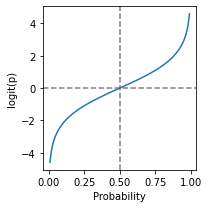

In [7]:
# 확률을 선형모형에 적합한 척도(로짓)로 매핑하기 위한 로짓 함수 그래프
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

### 로지스틱 회귀와 GLM
- 로지스틱 회귀는 선형회귀를 확장한 일반화 선형모형(GLM)의 특별한 사례이다.

In [10]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378908649112442
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


In [11]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [12]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.6380885430318344
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


### 로지스틱 회귀의 예측값
- 이 값들은 0~1사이에 있을 뿐이지, 아직 이 예측 결과가 연체인지 아니면 빚을 갚는 것인지는 분명히 말해주지 않는다.
- 기본으로 0.5보다 큰 값을 사용하면 판별할 수 있다. (이 기준값을 낮게 할수록 좋은 경우도 있다.)

In [13]:
# describe를 통해 분포의 특성을 알 수 있다.
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757872     -0.760434
std        0.378093      0.390456
min       -2.769376     -3.538593
25%       -0.985739     -0.977207
50%       -0.697406     -0.688907
75%       -0.472183     -0.467069
max       -0.029485     -0.064753


In [14]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500000      0.500000
std        0.167354      0.167354
min        0.062701      0.029054
25%        0.373163      0.376361
50%        0.497875      0.502125
75%        0.623639      0.626837
max        0.970946      0.937299


### 계수와 오즈비(odds ratio) 해석하기
- 로지스틱 회귀의 장점 중 하나는 재계산 없이 새 데이터에 대해 결과를 빨리 계산할 수 있다는 점이다.
- 또 다른 하나는 다른 분류 방법들에 비해 모델을 해석하기가 상대적으로 쉽다는 점이다.

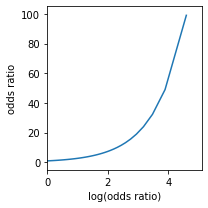

In [15]:
# 오즈비와 로그 오즈비 사이의 관계
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

### 선형회귀와 로지스틱 회귀 : 유사점과 차이점
- 선형회귀와 로지스틱 회귀는 모두 예측변수와 응답변수를 선형 관계로 가정한다.
- 하지만 모델을 피팅하는 방식, 모델에서 잔차의 특징과 분석하는 방식이 다르다.
#### 모델 피팅
- 선형회귀에서는 모델 피팅을 위해 최소제곱을 사용한다.
- 로지스틱 회귀분석에서는 닫힌 형태의 해가 없으므로 최대우도추정(MLE)을 사용하여 모델을 피팅해야한다.
- 최대우도추정이란, 우리가 보고 있는 데이터를 생성했을 가능성이 가장 큰 모델을 찾는 프로세스를 말한다.(피팅과정에서 편차라는 지표를 사용하여 모델을 평가한다. 편차가 작을 수록 모델 적합도가 높은 것을 의미한다.)
- MLE는 예상 로그 오즈비가 관찰된 결과를 가장 잘 설명하는 모델을 찾는다.
- 알고리즘은 현재 파라미터를 업데이트하는 단계를 계속적으로 반복하는 준뉴턴 최적화 메커니즘 으로 작동한다.

### 모델 평가하기
- 로지스틱 회귀는 출력이 이진변수라는 점만 빼면, 선형회귀와 매우 비슷하다.
- 선형모형과 비슷한 형태의 모델을 만들기 위해, 응답변수로 오즈비의 로그값을 사용하는 등의 몇가지 변환이 필요하다.
- 반복 과정을 통해 선형모형을 피팅하고 나면, 로그 오즈비는 다시 확률값으로 변환된다.
- 로지스틱 회귀는 계산 속도가 빠르고 새로운 데이터에 대해서도 간단한 산술연산으로 빠르게 결과를 구할 수 있다는 장점 때문에 많이 사용된다.

In [16]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Tue, 14 Nov 2023   Deviance:                       57515.
Time:                        16:17:24   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [17]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Tue, 14 Nov 2023   Deviance:                       57462.
Time:                                               16:18:11   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

### 잔차분석
- summary함수에서 어떤 출력은 사실상 무시할 수 있다.

In [ ]:
# 로지스틱 회귀에서 얻은 편잔차
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)e


plt.tight_layout()
plt.show()

### 분류 모델 평가하기
- 정확도(accuracy) : 정확히 분류된 비율
- 혼동행렬(confusion matrix) : 분류에서 예측된 결과와 실제 결과에 대한 레코드의 개수를 표시한 테이블
- 민감도(sensitivity), 재현율(recall) : 1을 정확히 1로 분류한 비율
- 특이도(specificity) : 0을 정확히 0으로 분류한 비율
- 정밀도(precision) : 1이라고 예측한 것들 중에 1이 맞는 경우의 비율
- ROC곡선 : 민감도와 특이성을 표시한 그림